In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils
import torch.utils.data
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from math import pi

In [2]:
# Define the exact solution u = H
def exact_solution_h(x, y, t):
    return -torch.sin(x)*torch.sin(y)*torch.cos(t)

def initial_condition_h(x, y):
    return -torch.sin(x)*torch.sin(y) 

In [3]:
# Define the exact solution p = E
def exact_solution_e1(x, y, t):
    return -torch.sin(x)*torch.sin(t)*torch.cos(y)

def initial_condition_e1(x, y):
    return 0.0*torch.sin(x) 

In [4]:
# Define the exact solution p = E
def exact_solution_e2(x, y, t):
    return torch.sin(y)*torch.sin(t)*torch.cos(x)

def initial_condition_e2(x, y):
    return 0.0*torch.sin(x) 

In [5]:
# assigning number of points
initial_pts = 200 
left_boundary_pts = 200 
right_boundary_pts = 200
back_boundary_pts = 200
front_boundary_pts = 200
residual_pts = 1000

In [6]:
# Type of optimizer (ADAM or LBFGS)
opt_type = "LBFGS"

x_init = torch.rand((initial_pts,1)) # initial pts
y_init = torch.rand((initial_pts,1))
t_init =  0*x_init
init =  torch.cat([x_init, y_init, t_init],1)
h_init = initial_condition_h(init[:,0], init[:, 1]).reshape(-1, 1)
e1_init = initial_condition_e1(init[:,0], init[:, 1]).reshape(-1, 1)
e2_init = initial_condition_e2(init[:,0], init[:, 1]).reshape(-1, 1)
w_init = torch.cat([h_init, e1_init, e2_init],1)


xb_left = torch.zeros((left_boundary_pts, 1)) # left spatial boundary
yb_left = torch.rand((left_boundary_pts, 1)) # left spatial boundary
tb_left = torch.rand((left_boundary_pts, 1)) # 
b_left = torch.cat([xb_left, yb_left, tb_left ],1)
h_b_l = exact_solution_h(xb_left, yb_left, tb_left).reshape(-1, 1)
e1_b_l = exact_solution_e1(xb_left, yb_left, tb_left).reshape(-1, 1)
e2_b_l = exact_solution_e2(xb_left, yb_left, tb_left).reshape(-1, 1)



xb_right = torch.ones((right_boundary_pts, 1)) # right spatial boundary
yb_right = torch.rand((right_boundary_pts, 1)) # right spatial boundary
tb_right = torch.rand((right_boundary_pts, 1)) # right boundary pts
b_right = torch.cat([xb_right, yb_right, tb_right ],1)
h_b_r = exact_solution_h(xb_right, yb_right, tb_right).reshape(-1, 1)
e1_b_r = exact_solution_e1(xb_right, yb_right, tb_right).reshape(-1, 1)
e2_b_r = exact_solution_e2(xb_right, yb_right, tb_right).reshape(-1, 1)



xb_front = torch.rand((front_boundary_pts, 1)) # front spatial boundary
yb_front = torch.zeros((front_boundary_pts, 1)) # front spatial boundary
tb_front = torch.rand((front_boundary_pts, 1)) # 
b_front = torch.cat([xb_front, yb_front, tb_front ],1)
h_b_f = exact_solution_h(xb_front, yb_front, tb_front).reshape(-1, 1)
e1_b_f = exact_solution_e1(xb_front, yb_front, tb_front).reshape(-1, 1)
e2_b_f = exact_solution_e2(xb_front, yb_front, tb_front).reshape(-1, 1)



xb_back = torch.rand((back_boundary_pts, 1)) # back spatial boundary
yb_back = torch.ones((back_boundary_pts, 1)) # back spatial boundary
tb_back = torch.rand((back_boundary_pts, 1)) # back boundary pts
b_back = torch.cat([xb_back, yb_back, tb_back ],1)
h_b_b = exact_solution_h(xb_back, yb_back, tb_back).reshape(-1, 1)
e1_b_b = exact_solution_e1(xb_back, yb_back, tb_back).reshape(-1, 1)
e2_b_b = exact_solution_e2(xb_back, yb_back, tb_back).reshape(-1, 1)



x_interior = torch.rand((residual_pts, 1))
y_interior = torch.rand((residual_pts, 1))
t_interior = torch.rand((residual_pts, 1))
interior = torch.cat([x_interior, y_interior, t_interior],1)





training_set = DataLoader(torch.utils.data.TensorDataset(init, w_init, b_left,  b_right, b_front, b_back), batch_size=200, shuffle=False)

In [7]:
class NeuralNet(nn.Module):

    def __init__(self, input_dimension, output_dimension, n_hidden_layers, neurons):
        super(NeuralNet, self).__init__()
        # Number of input dimensions n
        self.input_dimension = input_dimension
        # Number of output dimensions m
        self.output_dimension = output_dimension
        # Number of neurons per layer 
        self.neurons = neurons
        # Number of hidden layers 
        self.n_hidden_layers = n_hidden_layers
        # Activation function 
        self.activation = nn.Tanh()
        
        self.input_layer = nn.Linear(self.input_dimension, self.neurons)
        self.hidden_layers = nn.ModuleList([nn.Linear(self.neurons, self.neurons) for _ in range(n_hidden_layers)])
        self.output_layer = nn.Linear(self.neurons, self.output_dimension)

    def forward(self, x):
        # The forward function performs the set of affine and non-linear transformations defining the network 
        # (see equation above)
        x = self.activation(self.input_layer(x))
        for k, l in enumerate(self.hidden_layers):
            x = self.activation(l(x))
        return self.output_layer(x)


In [8]:
# Model definition
my_network = NeuralNet(input_dimension = init.shape[1], output_dimension = w_init.shape[1], n_hidden_layers=4, neurons=20)


In [9]:
def init_xavier(model, retrain_seed):
    torch.manual_seed(retrain_seed)
    def init_weights(m):
        if type(m) == nn.Linear and m.weight.requires_grad and m.bias.requires_grad:
            g = nn.init.calculate_gain('tanh')
            torch.nn.init.xavier_uniform_(m.weight, gain=g)
            #torch.nn.init.xavier_normal_(m.weight, gain=g)
            m.bias.data.fill_(0)
    model.apply(init_weights)

# Random Seed for weight initialization
retrain = 128
# Xavier weight initialization
init_xavier(my_network, retrain)
#print(my_network(init))

In [10]:
if opt_type == "ADAM":
    optimizer_ = optim.Adam(my_network.parameters(), lr=0.001)
elif opt_type == "LBFGS":
    optimizer_ = optim.LBFGS(my_network.parameters(), lr=0.1, max_iter=1, max_eval=50000, tolerance_change=1.0 * np.finfo(float).eps)
else:
    raise ValueError("Optimizer not recognized")

In [11]:
def fit(model, training_set, interior, num_epochs, optimizer, p, verbose=True):
    history = list()
    
    # Loop over epochs
    for epoch in range(num_epochs):
        if verbose: print("################################ ", epoch, " ################################")

        running_loss = list([0])
        
        # Loop over batches
        for j, (initial, w_initial, bd_left,  bd_right, bd_front, bd_back) in enumerate(training_set):
            
            def closure():
                # zero the parameter gradients
                optimizer.zero_grad()
                # for initial
                initial.requires_grad = True
                w_initial_pred_ = model(initial)
                h_initial_pred_ = w_initial_pred_[:,0].reshape(-1,1)
                e1_initial_pred_ = w_initial_pred_[:,1].reshape(-1,1)
                e2_initial_pred_ = w_initial_pred_[:,2].reshape(-1,1)
                
                
                # with derivative
                inpu = torch.ones(initial_pts, 1 )
                
                grad_h_ini = torch.autograd.grad(h_initial_pred_, initial, grad_outputs=inpu, create_graph=True, allow_unused=True)[0]
                h_initial_t = grad_h_ini[:, 2]
                
                grad_e1_ini = torch.autograd.grad(e1_initial_pred_, initial, grad_outputs=inpu, create_graph=True, allow_unused=True)[0]
                e1_initial_t = grad_e1_ini[:, 2]
                
                grad_e2_ini = torch.autograd.grad(e2_initial_pred_, initial, grad_outputs=inpu, create_graph=True, allow_unused=True)[0]
                e2_initial_t = grad_e2_ini[:, 2]
                
                
                
                # for left boundary
                w_bd_left_pred_ = model(bd_left)
                h_bd_left_pred_ = w_bd_left_pred_[:,0].reshape(-1,1)
                e1_bd_left_pred_ = w_bd_left_pred_[:,1].reshape(-1,1)
                e2_bd_left_pred_ = w_bd_left_pred_[:,2].reshape(-1,1)
                
                # for right boundary
                w_bd_right_pred_ = model(bd_right)
                h_bd_right_pred_ = w_bd_right_pred_[:,0].reshape(-1,1)
                e1_bd_right_pred_ = w_bd_right_pred_[:,1].reshape(-1,1)
                e2_bd_right_pred_ = w_bd_right_pred_[:,2].reshape(-1,1)
                
                # for front boundary
                w_bd_front_pred_ = model(bd_front)
                h_bd_front_pred_ = w_bd_front_pred_[:,0].reshape(-1,1)
                e1_bd_front_pred_ = w_bd_front_pred_[:,1].reshape(-1,1)
                e2_bd_front_pred_ = w_bd_front_pred_[:,2].reshape(-1,1)
                
                # for back boundary
                w_bd_back_pred_ = model(bd_back)
                h_bd_back_pred_ = w_bd_back_pred_[:,0].reshape(-1,1)
                e1_bd_back_pred_ = w_bd_back_pred_[:,1].reshape(-1,1)
                e2_bd_back_pred_ = w_bd_back_pred_[:,2].reshape(-1,1)
                
                # residual calculation
                interior.requires_grad = True
                w_hat = model(interior)
                h_hat = w_hat[:,0].reshape(-1,1)
                e1_hat = w_hat[:,1].reshape(-1,1)
                e2_hat = w_hat[:,2].reshape(-1,1)
                
                inputs = torch.ones(residual_pts, 1 )
                inputs2 = torch.ones(residual_pts, 1)
                
                grad_h_hat = torch.autograd.grad(h_hat.reshape(-1,1), interior, grad_outputs=inputs, create_graph=True)[0]
                h_x = grad_h_hat[:, 0].reshape(-1,1)
                h_y = grad_h_hat[:, 1].reshape(-1,1)
                
                grad_e1_hat = torch.autograd.grad(e1_hat, interior, grad_outputs=inputs, create_graph=True)[0]
                e1_x = grad_e1_hat[:, 0].reshape(-1,1)
                e1_y = grad_e1_hat[:, 1].reshape(-1,1)
                
                grad_e2_hat = torch.autograd.grad(e2_hat, interior, grad_outputs=inputs, create_graph=True)[0]
                e2_x = grad_e2_hat[:, 0].reshape(-1,1)
                e2_y = grad_e2_hat[:, 1].reshape(-1,1)
                
                h_t = grad_h_hat[:, 2].reshape(-1,1)
                e1_t = grad_e1_hat[:, 2].reshape(-1,1)
                e2_t = grad_e2_hat[:, 2].reshape(-1,1)
                
                
                # Item 1. below
                loss1 = torch.mean((h_initial_pred_.reshape(-1, ) - w_initial[:,0].reshape(-1, ))**p) + torch.mean((2*h_t.reshape(-1, ) + e2_x.reshape(-1, ) - e1_y.reshape(-1, ))**p)+torch.mean((h_bd_left_pred_.reshape(-1,)- h_b_l.reshape(-1,))**p) + torch.mean((h_bd_right_pred_.reshape(-1,)- h_b_r.reshape(-1,))**p) +torch.mean((h_bd_front_pred_.reshape(-1,)- h_b_f.reshape(-1,))**p) + torch.mean((h_bd_back_pred_.reshape(-1,)- h_b_b.reshape(-1,))**p)
                loss2 = torch.mean((e1_initial_pred_.reshape(-1, ) - w_initial[:,1].reshape(-1, ))**p)+ torch.mean((3*e1_t.reshape(-1, )  - h_y.reshape(-1, ) + 2*torch.sin(interior[:, 0])*torch.cos(interior[:, 2])*torch.cos(interior[:, 1]))**p) +torch.mean((e1_bd_left_pred_.reshape(-1,)- e1_b_l.reshape(-1,))**p) + torch.mean((e1_bd_right_pred_.reshape(-1,)- e1_b_r.reshape(-1,))**p) +torch.mean((e1_bd_front_pred_.reshape(-1,)- e1_b_f.reshape(-1,))**p) + torch.mean((e1_bd_back_pred_.reshape(-1,)- e1_b_b.reshape(-1,))**p)
                loss3 = torch.mean((e2_initial_pred_.reshape(-1, ) - w_initial[:,2].reshape(-1, ))**p)+ torch.mean((2*e2_t.reshape(-1, )  + h_x.reshape(-1, ) - torch.cos(interior[:, 0])*torch.cos(interior[:, 2])*torch.sin(interior[:, 1]))**p) +torch.mean((e2_bd_left_pred_.reshape(-1,)- e2_b_l.reshape(-1,))**p) + torch.mean((e2_bd_right_pred_.reshape(-1,)- e2_b_r.reshape(-1,))**p) +torch.mean((e2_bd_front_pred_.reshape(-1,)- e2_b_f.reshape(-1,))**p) + torch.mean((e2_bd_back_pred_.reshape(-1,)- e2_b_b.reshape(-1,))**p)
                loss = loss1 + loss2 + loss3
                
                # Item 2. below
                loss.backward()
                # Compute average training loss over batches for the current epoch
                running_loss[0] += loss.item()
                return loss
            
            # Item 3. below
            optimizer.step(closure=closure)
            
        print('Loss: ', (running_loss[0] / len(training_set)))
        history.append(running_loss[0])

    return history


In [12]:
n_epochs = 1500
history = fit(my_network, training_set, interior, n_epochs, optimizer_, p=2, verbose=True )

################################  0  ################################
Loss:  99.23579406738281
################################  1  ################################
Loss:  97.35958099365234
################################  2  ################################
Loss:  83.40977478027344
################################  3  ################################
Loss:  68.36258697509766
################################  4  ################################
Loss:  52.6787109375
################################  5  ################################
Loss:  39.63242721557617
################################  6  ################################
Loss:  32.06940460205078
################################  7  ################################
Loss:  27.531774520874023
################################  8  ################################
Loss:  24.084901809692383
################################  9  ################################
Loss:  21.137191772460938
################################  10  #############

Loss:  0.01483091339468956
################################  91  ################################
Loss:  0.01407969556748867
################################  92  ################################
Loss:  0.013355374336242676
################################  93  ################################
Loss:  0.012695414945483208
################################  94  ################################
Loss:  0.012096638791263103
################################  95  ################################
Loss:  0.011541255749762058
################################  96  ################################
Loss:  0.011041149497032166
################################  97  ################################
Loss:  0.010570930317044258
################################  98  ################################
Loss:  0.010146447457373142
################################  99  ################################
Loss:  0.009759914129972458
################################  100  ################################
Loss:  0.00

Loss:  0.0019565210677683353
################################  183  ################################
Loss:  0.0019244318827986717
################################  184  ################################
Loss:  0.001889770501293242
################################  185  ################################
Loss:  0.0018558581359684467
################################  186  ################################
Loss:  0.0018209712579846382
################################  187  ################################
Loss:  0.0017891887109726667
################################  188  ################################
Loss:  0.001758954836986959
################################  189  ################################
Loss:  0.0017291014082729816
################################  190  ################################
Loss:  0.0017002111999318004
################################  191  ################################
Loss:  0.0016738285776227713
################################  192  #########################

Loss:  0.0008271568804048002
################################  267  ################################
Loss:  0.000817072403151542
################################  268  ################################
Loss:  0.0008074887446127832
################################  269  ################################
Loss:  0.0007980220834724605
################################  270  ################################
Loss:  0.0007890711422078311
################################  271  ################################
Loss:  0.0007803854532539845
################################  272  ################################
Loss:  0.000772117346059531
################################  273  ################################
Loss:  0.0007643455173820257
################################  274  ################################
Loss:  0.0007576111238449812
################################  275  ################################
Loss:  0.0007515241159126163
################################  276  #########################

Loss:  0.0005257374723441899
################################  363  ################################
Loss:  0.0005230936221778393
################################  364  ################################
Loss:  0.0005205743946135044
################################  365  ################################
Loss:  0.0005179831641726196
################################  366  ################################
Loss:  0.000515442923642695
################################  367  ################################
Loss:  0.0005128545453771949
################################  368  ################################
Loss:  0.0005102171562612057
################################  369  ################################
Loss:  0.0005076696397736669
################################  370  ################################
Loss:  0.0005052704946137965
################################  371  ################################
Loss:  0.000502972980029881
################################  372  #########################

Loss:  0.0003861341974698007
################################  452  ################################
Loss:  0.00038462987868115306
################################  453  ################################
Loss:  0.0003831151989288628
################################  454  ################################
Loss:  0.0003817088436335325
################################  455  ################################
Loss:  0.00038025015965104103
################################  456  ################################
Loss:  0.0003788794274441898
################################  457  ################################
Loss:  0.00037745802546851337
################################  458  ################################
Loss:  0.00037592335138469934
################################  459  ################################
Loss:  0.0003744079149328172
################################  460  ################################
Loss:  0.0003729805466718972
################################  461  ###################

Loss:  0.0002820705994963646
################################  544  ################################
Loss:  0.0002809080178849399
################################  545  ################################
Loss:  0.0002798840869218111
################################  546  ################################
Loss:  0.00027885069721378386
################################  547  ################################
Loss:  0.00027786559076048434
################################  548  ################################
Loss:  0.00027684037922881544
################################  549  ################################
Loss:  0.0002756597241386771
################################  550  ################################
Loss:  0.0002743912336882204
################################  551  ################################
Loss:  0.00027325021801516414
################################  552  ################################
Loss:  0.0002721597265917808
################################  553  ###################

Loss:  0.00020578238763846457
################################  639  ################################
Loss:  0.00020523893181234598
################################  640  ################################
Loss:  0.00020469698938541114
################################  641  ################################
Loss:  0.00020415851031430066
################################  642  ################################
Loss:  0.00020365053205750883
################################  643  ################################
Loss:  0.0002031274198088795
################################  644  ################################
Loss:  0.0002025803696596995
################################  645  ################################
Loss:  0.00020200430299155414
################################  646  ################################
Loss:  0.00020145345479249954
################################  647  ################################
Loss:  0.00020095046784263104
################################  648  ###############

Loss:  0.00015083790640346706
################################  734  ################################
Loss:  0.00015039295249152929
################################  735  ################################
Loss:  0.00014993605145718902
################################  736  ################################
Loss:  0.00014947712770663202
################################  737  ################################
Loss:  0.00014901257236488163
################################  738  ################################
Loss:  0.00014854836626909673
################################  739  ################################
Loss:  0.0001480831124354154
################################  740  ################################
Loss:  0.00014761334750801325
################################  741  ################################
Loss:  0.00014713633572682738
################################  742  ################################
Loss:  0.00014667405048385262
################################  743  ##############

Loss:  0.00010865223885048181
################################  821  ################################
Loss:  0.00010835380817297846
################################  822  ################################
Loss:  0.00010808498336700723
################################  823  ################################
Loss:  0.00010782858589664102
################################  824  ################################
Loss:  0.00010757487325463444
################################  825  ################################
Loss:  0.00010733586532296613
################################  826  ################################
Loss:  0.00010710334754548967
################################  827  ################################
Loss:  0.00010688035399653018
################################  828  ################################
Loss:  0.00010666767047950998
################################  829  ################################
Loss:  0.00010646114242263138
################################  830  #############

Loss:  8.507068559993058e-05
################################  917  ################################
Loss:  8.481297118123621e-05
################################  918  ################################
Loss:  8.456136856693774e-05
################################  919  ################################
Loss:  8.432436879957095e-05
################################  920  ################################
Loss:  8.411436283495277e-05
################################  921  ################################
Loss:  8.390344009967521e-05
################################  922  ################################
Loss:  8.37172192404978e-05
################################  923  ################################
Loss:  8.35213577374816e-05
################################  924  ################################
Loss:  8.335110760526732e-05
################################  925  ################################
Loss:  8.317948959302157e-05
################################  926  #########################

Loss:  6.90255910740234e-05
################################  1013  ################################
Loss:  6.893817044328898e-05
################################  1014  ################################
Loss:  6.882822344778106e-05
################################  1015  ################################
Loss:  6.873933307360858e-05
################################  1016  ################################
Loss:  6.858147389721125e-05
################################  1017  ################################
Loss:  6.840098649263382e-05
################################  1018  ################################
Loss:  6.814131484134123e-05
################################  1019  ################################
Loss:  6.786709855077788e-05
################################  1020  ################################
Loss:  6.752533954568207e-05
################################  1021  ################################
Loss:  6.724208651576191e-05
################################  1022  ##############

Loss:  5.679182140738703e-05
################################  1094  ################################
Loss:  5.671848339261487e-05
################################  1095  ################################
Loss:  5.66372909815982e-05
################################  1096  ################################
Loss:  5.6553846661699936e-05
################################  1097  ################################
Loss:  5.6467491958756e-05
################################  1098  ################################
Loss:  5.6378921726718545e-05
################################  1099  ################################
Loss:  5.629180668620393e-05
################################  1100  ################################
Loss:  5.6202945415861905e-05
################################  1101  ################################
Loss:  5.611540109384805e-05
################################  1102  ################################
Loss:  5.6025590311037377e-05
################################  1103  ############

Loss:  5.00848691444844e-05
################################  1184  ################################
Loss:  5.000861347070895e-05
################################  1185  ################################
Loss:  4.9930913519347087e-05
################################  1186  ################################
Loss:  4.985466512152925e-05
################################  1187  ################################
Loss:  4.97779983561486e-05
################################  1188  ################################
Loss:  4.969767906004563e-05
################################  1189  ################################
Loss:  4.962035018252209e-05
################################  1190  ################################
Loss:  4.9543912609806284e-05
################################  1191  ################################
Loss:  4.946726403431967e-05
################################  1192  ################################
Loss:  4.939391146763228e-05
################################  1193  #############

Loss:  4.2499326809775084e-05
################################  1280  ################################
Loss:  4.2450679757166654e-05
################################  1281  ################################
Loss:  4.2401741666253656e-05
################################  1282  ################################
Loss:  4.2355022742412984e-05
################################  1283  ################################
Loss:  4.2307638068450615e-05
################################  1284  ################################
Loss:  4.22597186116036e-05
################################  1285  ################################
Loss:  4.221247945679352e-05
################################  1286  ################################
Loss:  4.2163985199294984e-05
################################  1287  ################################
Loss:  4.211722261970863e-05
################################  1288  ################################
Loss:  4.2069554183399305e-05
################################  1289  #######

Loss:  3.869826832669787e-05
################################  1362  ################################
Loss:  3.864684913423844e-05
################################  1363  ################################
Loss:  3.8599930121563375e-05
################################  1364  ################################
Loss:  3.855093746096827e-05
################################  1365  ################################
Loss:  3.851393921650015e-05
################################  1366  ################################
Loss:  3.847908737952821e-05
################################  1367  ################################
Loss:  3.844232560368255e-05
################################  1368  ################################
Loss:  3.8405501982197165e-05
################################  1369  ################################
Loss:  3.837255644612014e-05
################################  1370  ################################
Loss:  3.8338541344273835e-05
################################  1371  ##########

Loss:  3.442759407334961e-05
################################  1444  ################################
Loss:  3.436015686020255e-05
################################  1445  ################################
Loss:  3.42915445799008e-05
################################  1446  ################################
Loss:  3.4223165130242705e-05
################################  1447  ################################
Loss:  3.416255640331656e-05
################################  1448  ################################
Loss:  3.409524288144894e-05
################################  1449  ################################
Loss:  3.4041899198200554e-05
################################  1450  ################################
Loss:  3.3991149393841624e-05
################################  1451  ################################
Loss:  3.393841689103283e-05
################################  1452  ################################
Loss:  3.389770063222386e-05
################################  1453  ###########

In [13]:
# saving and loading Model
FILE = "maxwell2D_2.pth"
torch.save(my_network, FILE)

# uncomment below when you need to test for different points
#my_network = torch.load(FILE)
#my_network.eval()

In [14]:
# saving and loading Model (this model with reported results)
#FILE = "second.pth"
#torch.save(my_network, FILE)

# uncomment below when you need to test for different points
#my_network = torch.load(FILE)
#my_network.eval()

In [15]:
x_test = torch.linspace(0, 1, 10000).reshape(-1,1)
y_test = torch.linspace(0, 1, 10000).reshape(-1,1)
t_test = torch.ones((10000,1))
test = torch.cat([x_test, y_test, t_test],1)
h_test = exact_solution_h(x_test, y_test, t_test).reshape(-1,1)
e1_test = exact_solution_e1(x_test, y_test, t_test).reshape(-1,1)
e2_test = exact_solution_e2(x_test, y_test, t_test).reshape(-1,1)
w_test_pred = my_network(test)
h_test_pred = w_test_pred[:,0].reshape(-1,1)
e1_test_pred = w_test_pred[:,1].reshape(-1,1)
e2_test_pred = w_test_pred[:,2].reshape(-1,1)

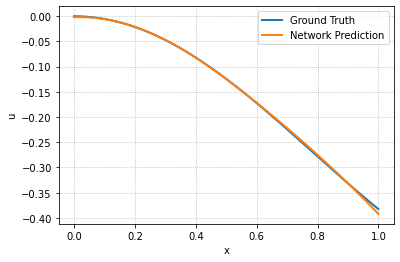

In [16]:
plt.grid(True, which="both", ls=":")
plt.plot(x_test, h_test, label="Ground Truth",lw=2)
plt.plot(x_test, h_test_pred.detach(), label="Network Prediction",lw=2)
plt.xlabel("x")
plt.ylabel("u")
plt.legend()

In [17]:
# Compute the relative L2 error norm (generalization error)
relative_error_test = torch.mean((h_test_pred - h_test)**2)/torch.mean(h_test**2)
#relative_error_test = torch.max(torch.abs(u_test_pred -u_test))/torch.max(torch.abs(u_test))
print("Relative Error Test: ", relative_error_test.detach().numpy()*100, "%")

Relative Error Test:  0.011657299182843417 %


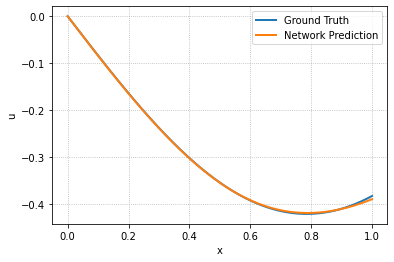

In [18]:
plt.grid(True, which="both", ls=":")
plt.plot(x_test, e1_test, label="Ground Truth",lw=2)
plt.plot(x_test, e1_test_pred.detach(), label="Network Prediction",lw=2)
plt.xlabel("x")
plt.ylabel("u")
plt.legend()

In [19]:
# Compute the relative L2 error norm (generalization error)
relative_error_test = torch.mean((e1_test_pred - e1_test)**2)/torch.mean(e1_test**2)
#relative_error_test = torch.max(torch.abs(u_test_pred -u_test))/torch.max(torch.abs(u_test))
print("Relative Error Test: ", relative_error_test.detach().numpy()*100, "%")

Relative Error Test:  0.0020642175513785332 %


In [20]:
# Compute the relative L2 error norm (generalization error)
relative_error_test = torch.mean((e2_test_pred - e2_test)**2)/torch.mean(e2_test**2)
#relative_error_test = torch.max(torch.abs(u_test_pred -u_test))/torch.max(torch.abs(u_test))
print("Relative Error Test: ", relative_error_test.detach().numpy()*100, "%")

Relative Error Test:  0.002686636616999749 %


In [21]:
# for ploting

In [22]:
model = my_network
x_test = pi*torch.rand(100000).reshape(-1,1)
t_test = torch.rand(100000).reshape(-1,1)
test = torch.cat([x_test, t_test],1)
u_test = exact_solution_u(x_test,t_test).reshape(-1,1)
p_test = exact_solution_p(x_test,t_test).reshape(-1,1)
u_test_pred = my_network(test)
u_pred = u_test_pred[:, 0].reshape(-1,1)

u_pred1 = u_test_pred[:, 1].reshape(-1,1)


relative_error = torch.abs(u_pred- u_test)

relative_error1 = torch.abs(u_pred1- p_test)
u_pred = u_pred.detach().numpy()
x_test = x_test.detach().numpy()
t_test = t_test.detach().numpy()
p_pred = u_pred1.detach().numpy()
relative_error = relative_error.detach().numpy()
relative_error1 = relative_error1.detach().numpy()

NameError: name 'exact_solution_u' is not defined

In [ ]:

x_test = x_test.reshape(-1,)
t_test = t_test.reshape(-1,)

u_pred = u_pred.reshape(-1,)
p_pred = p_pred.reshape(-1,)

In [ ]:

plt.rcParams['figure.figsize'] = [10, 4]


CS = plt.tricontourf(x_test, t_test, u_pred, 20, cmap='turbo')


cbar = plt.colorbar(CS)
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(20)


plt.xlabel('x', fontsize=20)
plt.ylabel('t', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


#plt.savefig('timo_u.png', dpi = 300, bbox_inches = "tight")

In [ ]:
CS = plt.tricontourf(x_test, t_test, p_pred, 20, cmap='turbo')


cbar = plt.colorbar(CS)
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(20)


plt.xlabel('x', fontsize=20)
plt.ylabel('t', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

#plt.savefig('timo_p.png', dpi = 300, bbox_inches = "tight")

In [ ]:

x_test = x_test.reshape(-1, )
t_test = t_test.reshape(-1, )
relative_error = relative_error.reshape(-1,)




CS = plt.tricontourf(x_test, t_test, relative_error, 20, cmap='turbo')


cbar = plt.colorbar(CS)
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(20)


plt.xlabel('x', fontsize=20)
plt.ylabel('t', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

#plt.savefig('relative_error_timo_u.png', dpi = 300, bbox_inches = "tight")

In [ ]:
relative_error1 = relative_error1.reshape(-1,)

CS = plt.tricontourf(x_test, t_test, relative_error1, 20, cmap='turbo')


cbar = plt.colorbar(CS)
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(20)


plt.xlabel('x', fontsize=20)
plt.ylabel('t', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

#plt.savefig('relative_error_timo_p.png', dpi = 300, bbox_inches = "tight")